In [23]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import time
import pandas as pd
import numpy as np
import scipy.stats as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%autoreload

# load files
base_folder = '/scratch/datasets/ddls/sims/'
base_name = 'cluster'
ids = [22, 24, 26]


steps_logs_dict = defaultdict(lambda : defaultdict(list))
sim_logs_dict = defaultdict(lambda : defaultdict(list))
start_time = time.time()
for i in ids:
    agent = base_name + f'_{i}'
    paths = [reset_folder for reset_folder in glob.glob(base_folder + f'/{base_name}/{agent}/*/')]
    print(f'i: {i} | agent: {agent} | paths: {paths}')
    
    for path in paths:
        with SqliteDict(path + '/steps_log.sqlite') as log:
            for key, val in log.items():
                steps_logs_dict[agent][key].extend(val)
            log.close()

        with SqliteDict(path + '/sim_log.sqlite') as log:
            for key, val in log.items():
                sim_logs_dict[agent][key].extend(val)
            log.close()

i: 22 | agent: cluster_22 | paths: ['/scratch/datasets/ddls/sims//cluster/cluster_22/reset_2/', '/scratch/datasets/ddls/sims//cluster/cluster_22/reset_1/', '/scratch/datasets/ddls/sims//cluster/cluster_22/reset_3/']
i: 24 | agent: cluster_24 | paths: ['/scratch/datasets/ddls/sims//cluster/cluster_24/reset_2/', '/scratch/datasets/ddls/sims//cluster/cluster_24/reset_1/', '/scratch/datasets/ddls/sims//cluster/cluster_24/reset_3/']
i: 26 | agent: cluster_26 | paths: ['/scratch/datasets/ddls/sims//cluster/cluster_26/reset_2/', '/scratch/datasets/ddls/sims//cluster/cluster_26/reset_1/', '/scratch/datasets/ddls/sims//cluster/cluster_26/reset_3/']


In [37]:
# augment logs dict as desired

# def augment_steps_logs_dict(steps_logs_dict):
#     for agent in steps_logs_dict.keys():
        
# #         wallclock time
# #         steps_logs_dict[agent]['wallclock_time'] = [steps_logs_dict[agent]['step_end_time'][0]]
# #         for step_end_time in steps_logs_dict[agent]['step_end_time'][1:]:
# #             steps_logs_dict[agent]['wallclock_time'].append(steps_logs_dict[agent]['wallclock_time'][-1] + step_end_time)
#     steps_logs_dict = []
    
#     return steps_logs_dict
            
# steps_logs_dict = augment_steps_logs_dict(steps_logs_dict)
        
print(f'\nsteps_logs_dict: {steps_logs_dict}\n')
print(f'\nsim_logs_dict: {sim_logs_dict}\n')
print(f'\nAll data loaded in {time.time() - start_time:.3f} s.')


steps_logs_dict: defaultdict(<function <lambda> at 0x7fd1af413ca0>, {'cluster_22': defaultdict(<class 'list'>, {'step_counter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 

# Steps logs plots

Metrics to plot: ['job_queue_length', 'mean_num_active_workers', 'num_jobs_arrived', 'num_jobs_blocked', 'num_jobs_completed', 'num_jobs_running', 'step_counter', 'step_start_time']
Metrics to skip: {'step_end_time'}

Plotting metric job_queue_length


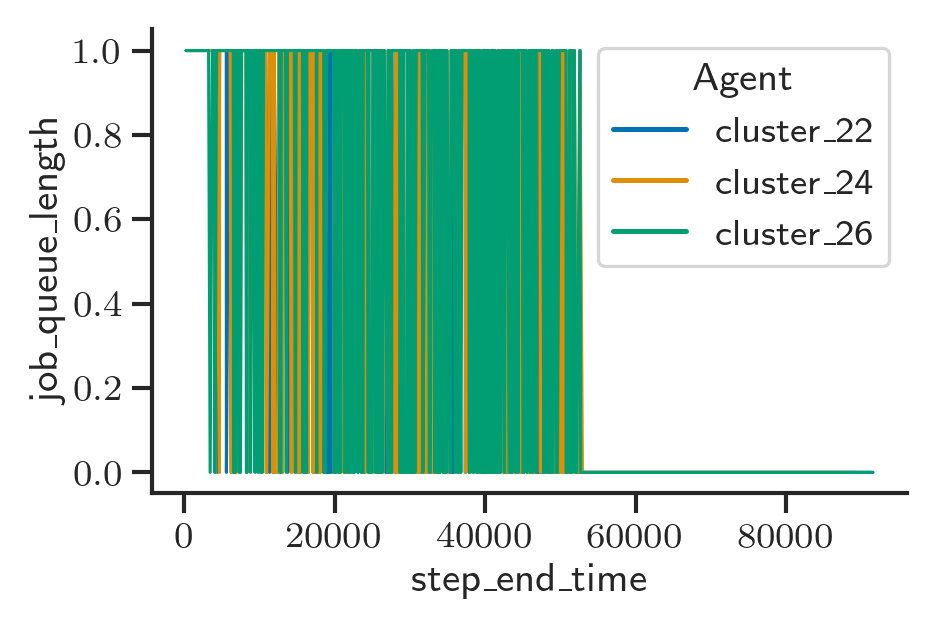

Plotting metric mean_num_active_workers


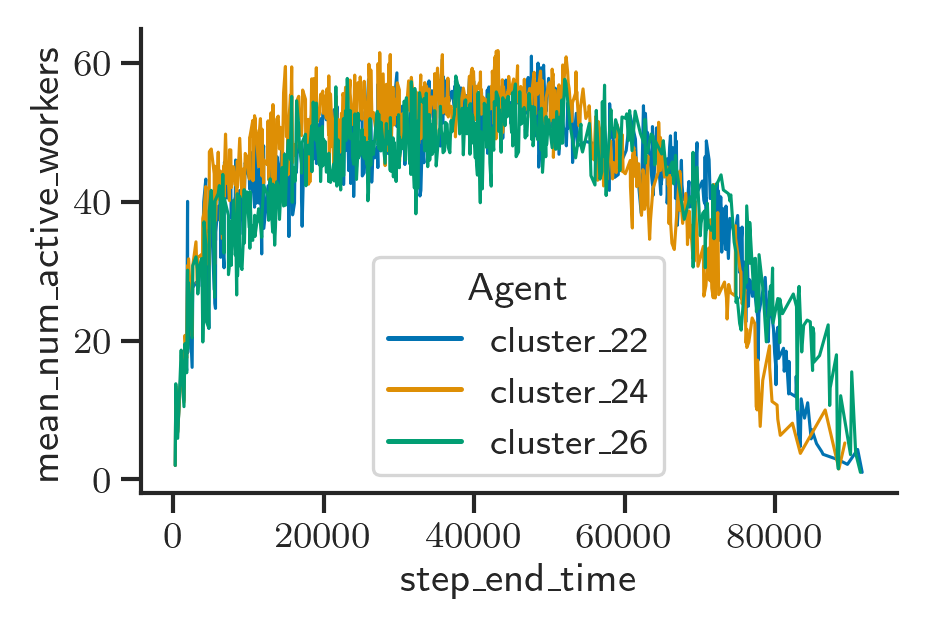

Plotting metric num_jobs_arrived


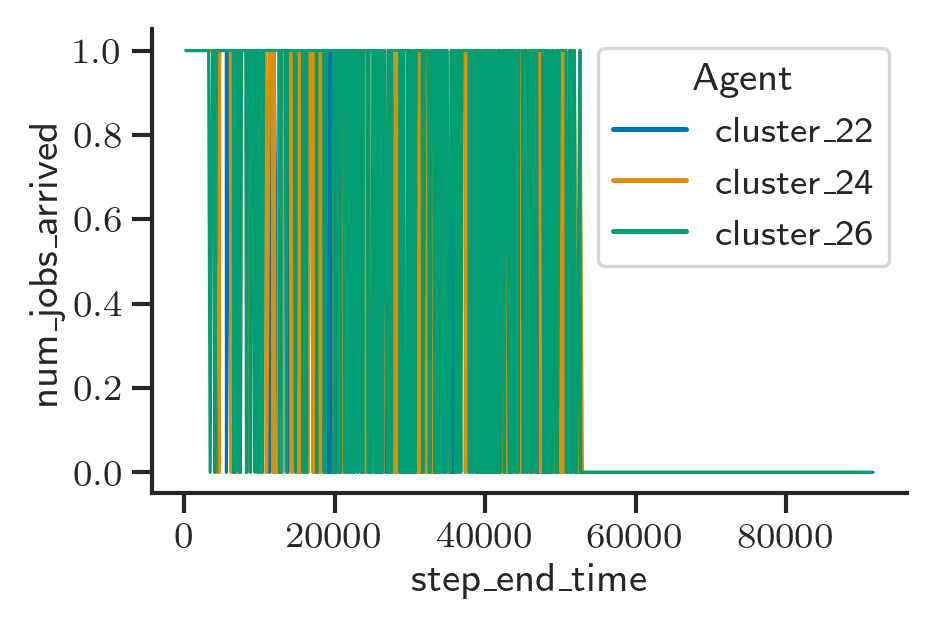

Plotting metric num_jobs_blocked


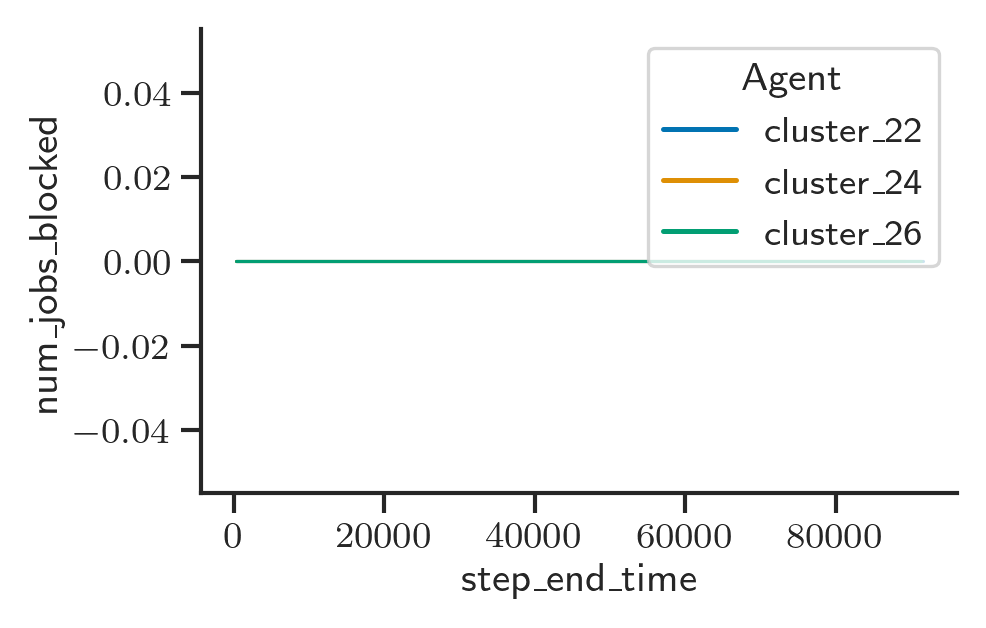

Plotting metric num_jobs_completed


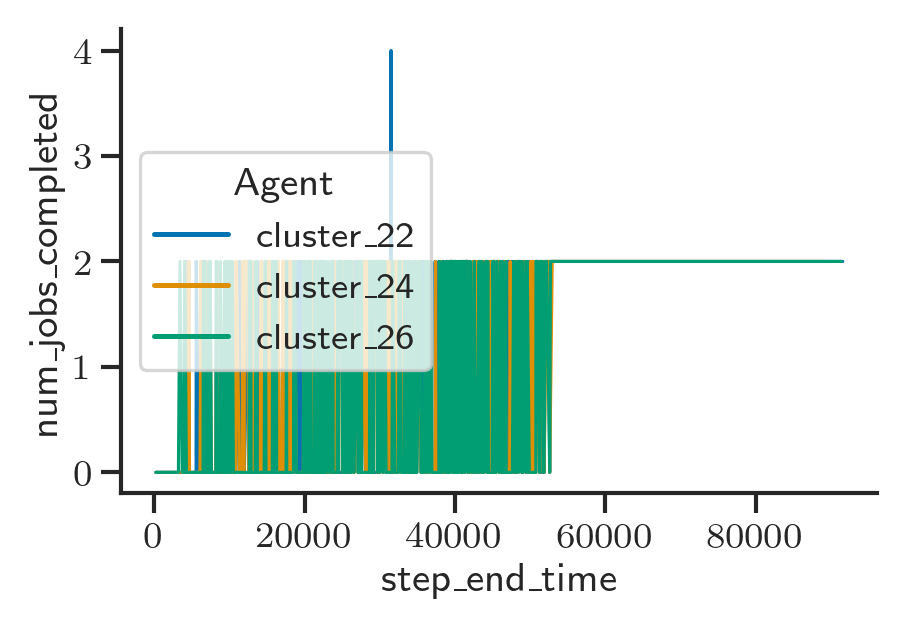

Plotting metric num_jobs_running


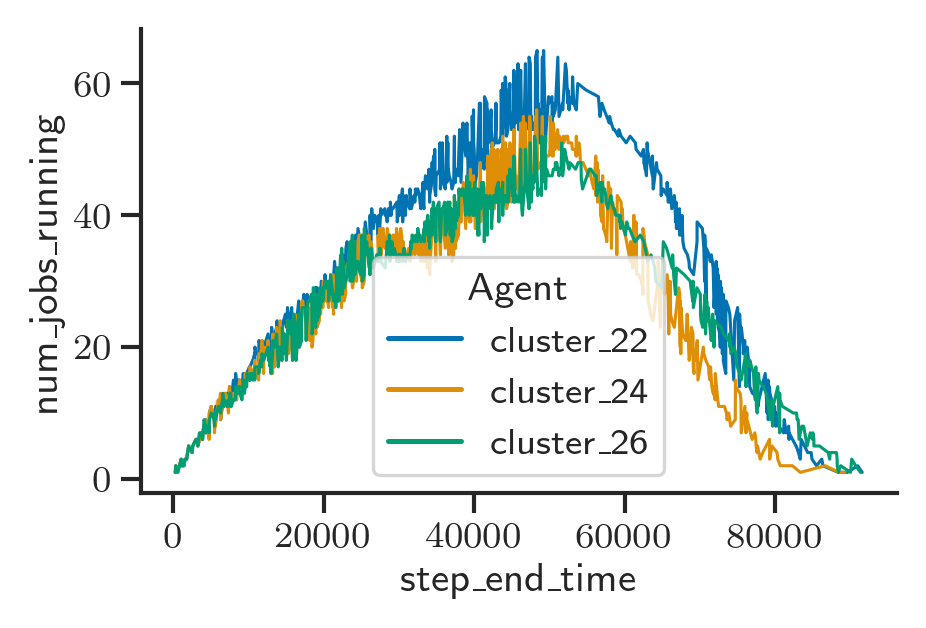

Plotting metric step_counter


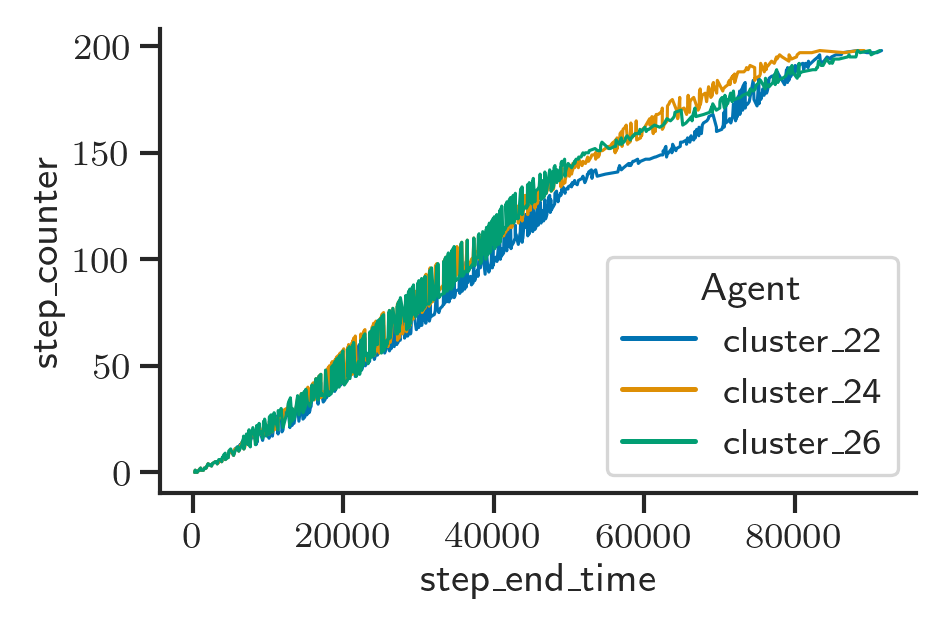

Plotting metric step_start_time


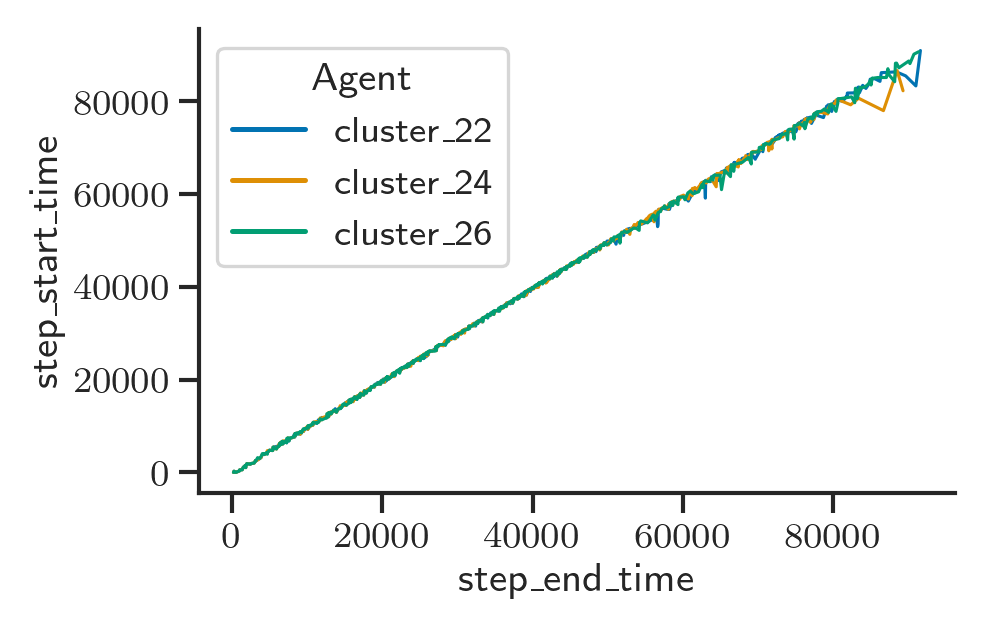

In [39]:
%autoreload

# plot config
# x = 'step_counter'
x = 'step_end_time'
scaling_factor = 1
metrics_to_skip = {x}

# make plots
metrics = steps_logs_dict[agent].keys()
metrics_to_plot = sorted([metric for metric in metrics if metric not in metrics_to_skip])
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = defaultdict(list)
    for _agent in steps_logs_dict.keys():
        plot_dict['Agent'].extend([_agent for _ in range(len(steps_logs_dict[_agent][metric]))])
        plot_dict[x].extend(steps_logs_dict[_agent][x])
        plot_dict[metric].extend(steps_logs_dict[_agent][metric])
    fig = plot_line(pd.DataFrame(plot_dict), 
                    x=x, 
                    y=metric, 
                    hue='Agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=True)

# Sim logs plots

Metrics to plot: ['job_completion_time', 'jobs_completed_num_edges', 'jobs_completed_num_nodes', 'jobs_completed_total_dependency_size', 'jobs_completed_total_operation_memory_cost']
Metrics to skip: {}

Plotting metric job_completion_time


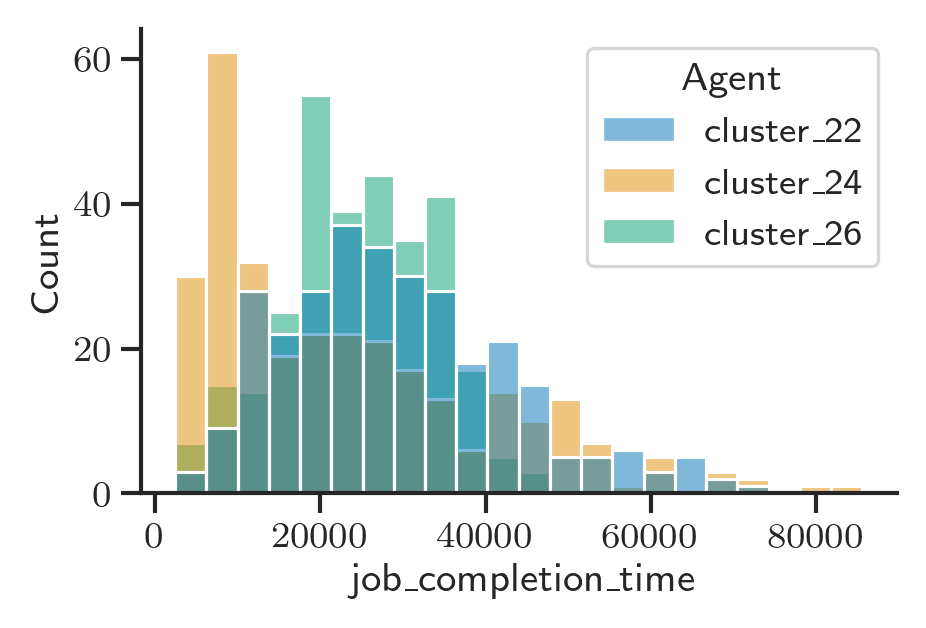

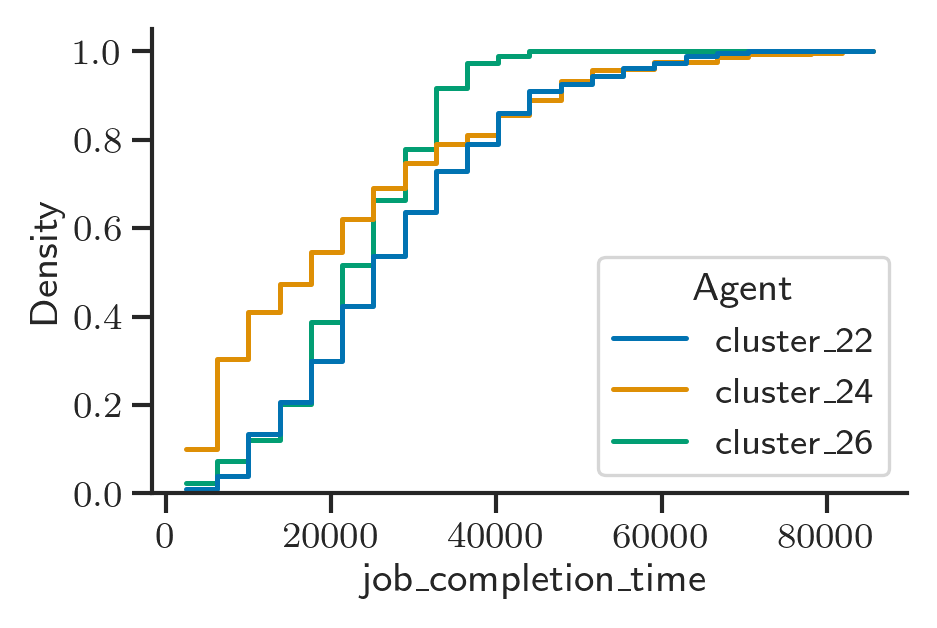

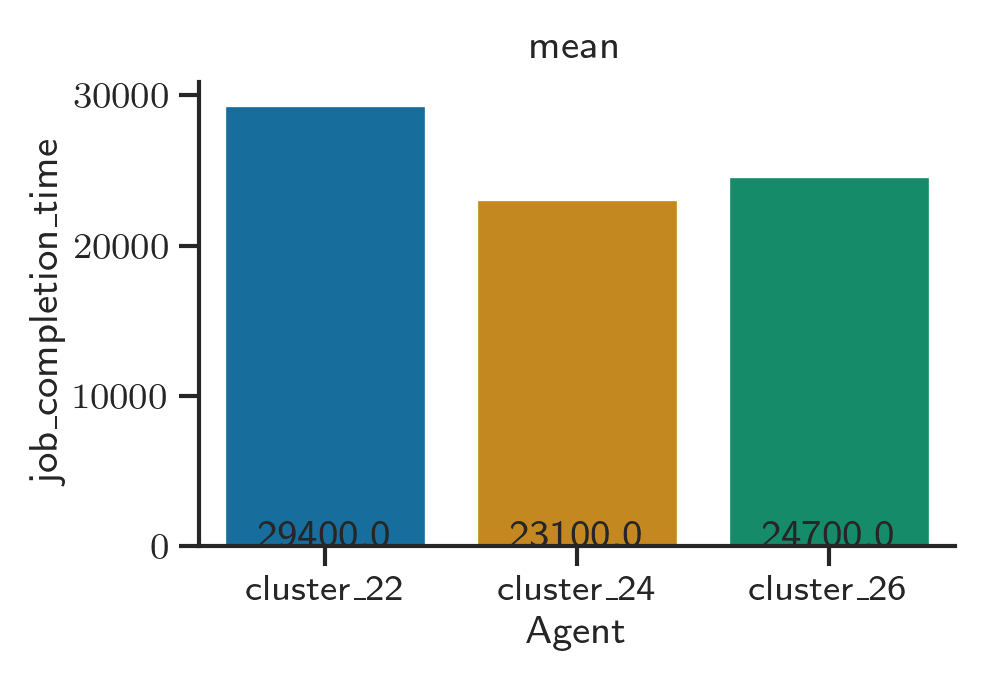

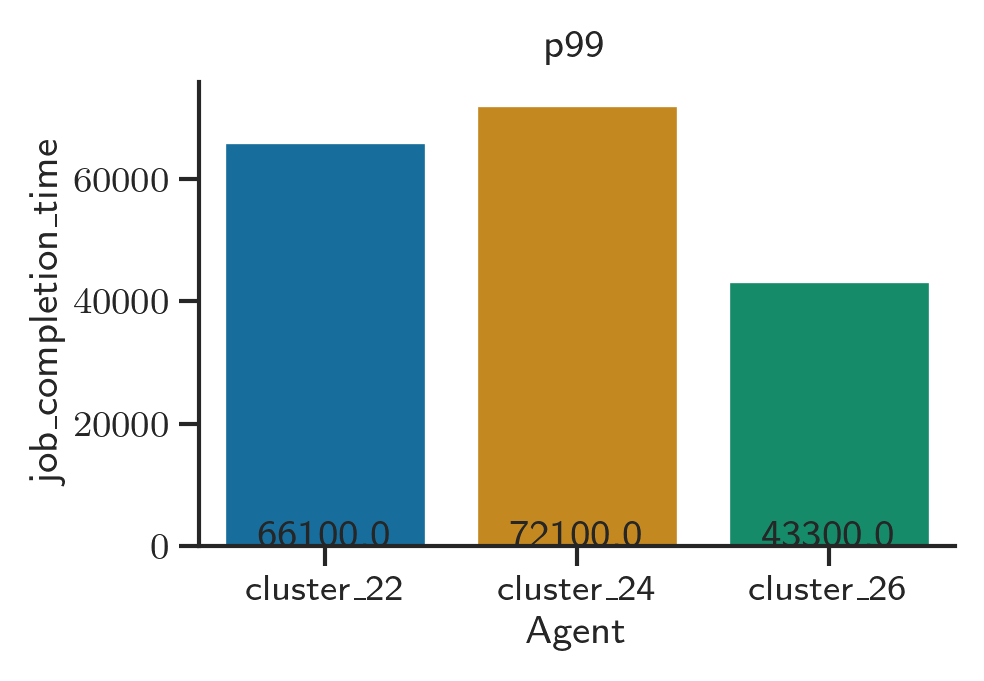

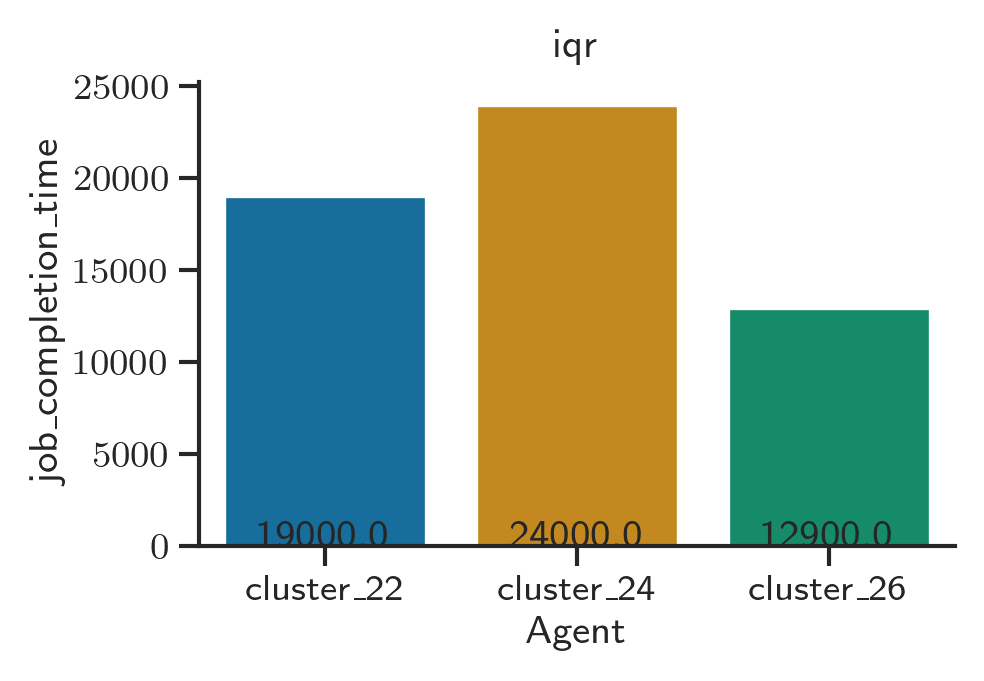

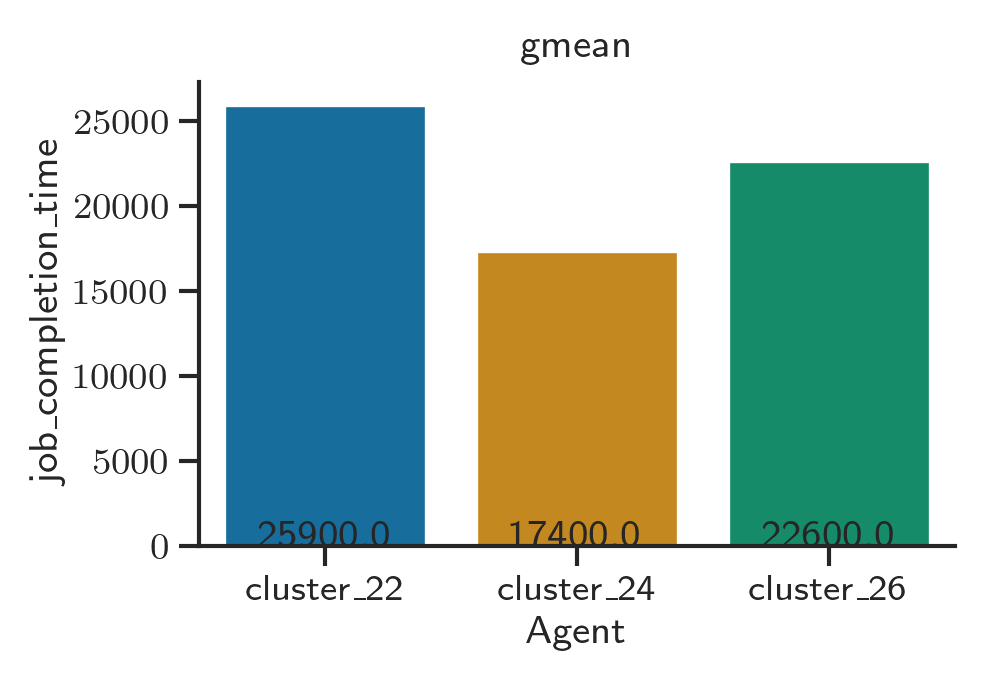

Plotting metric jobs_completed_num_edges


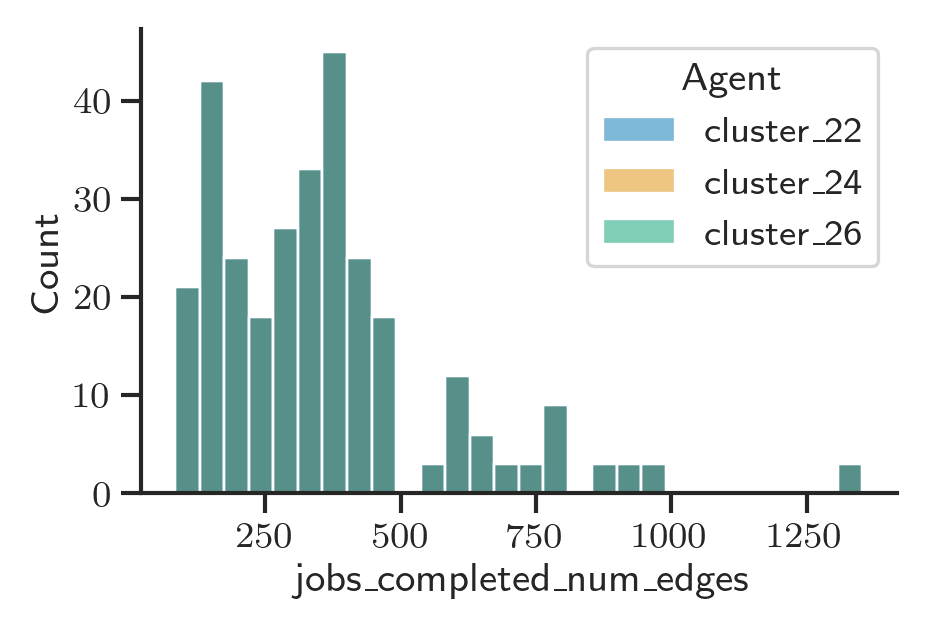

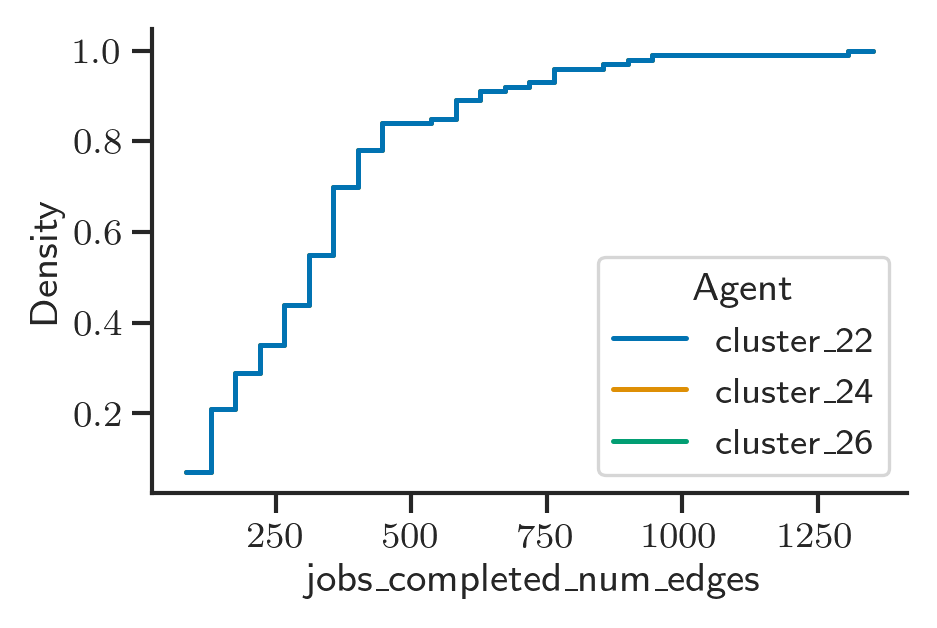

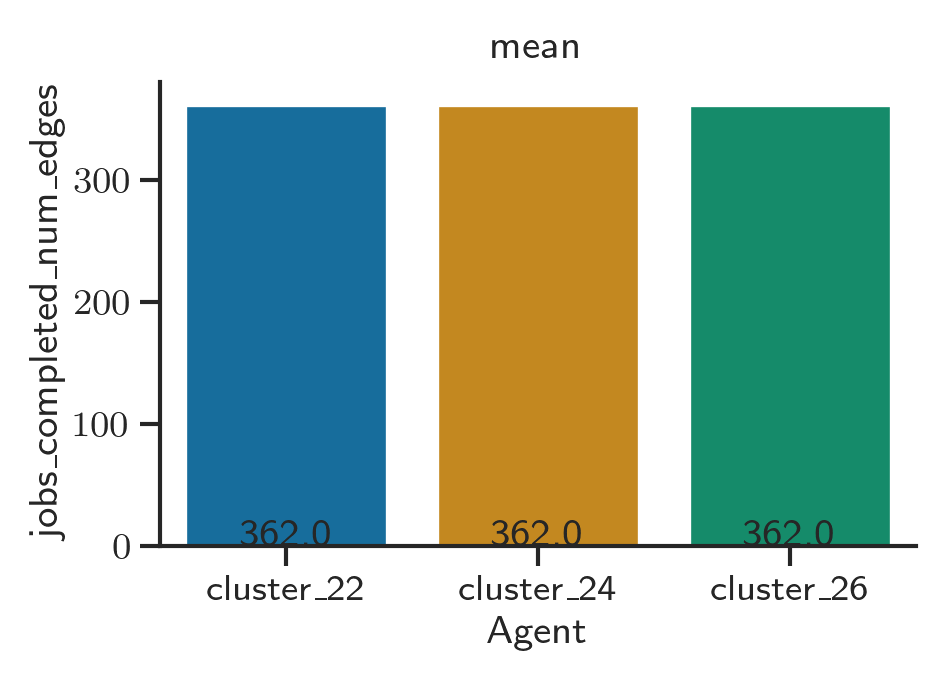

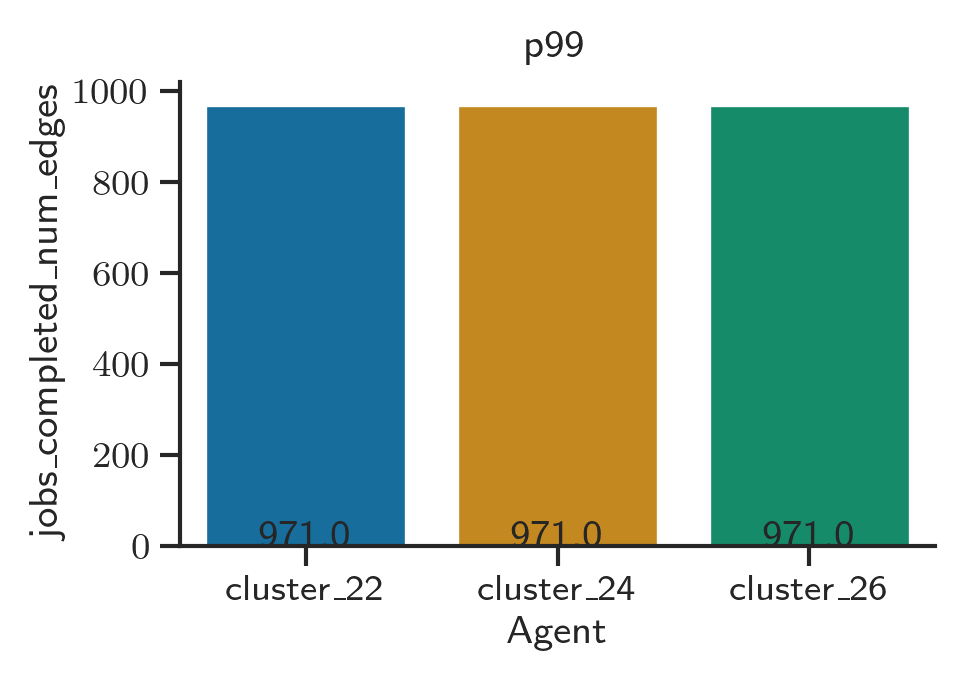

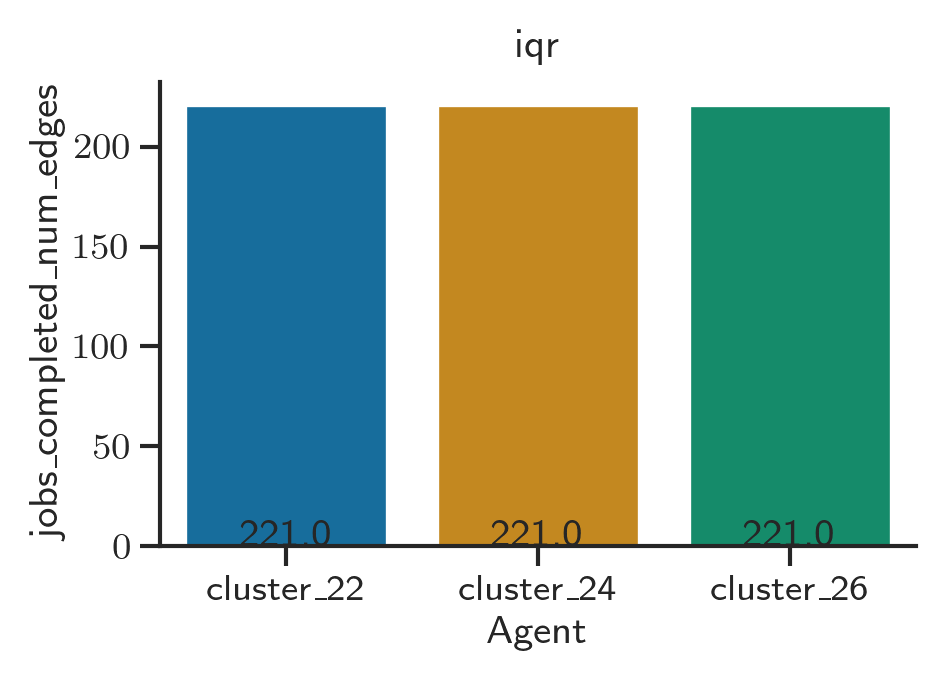

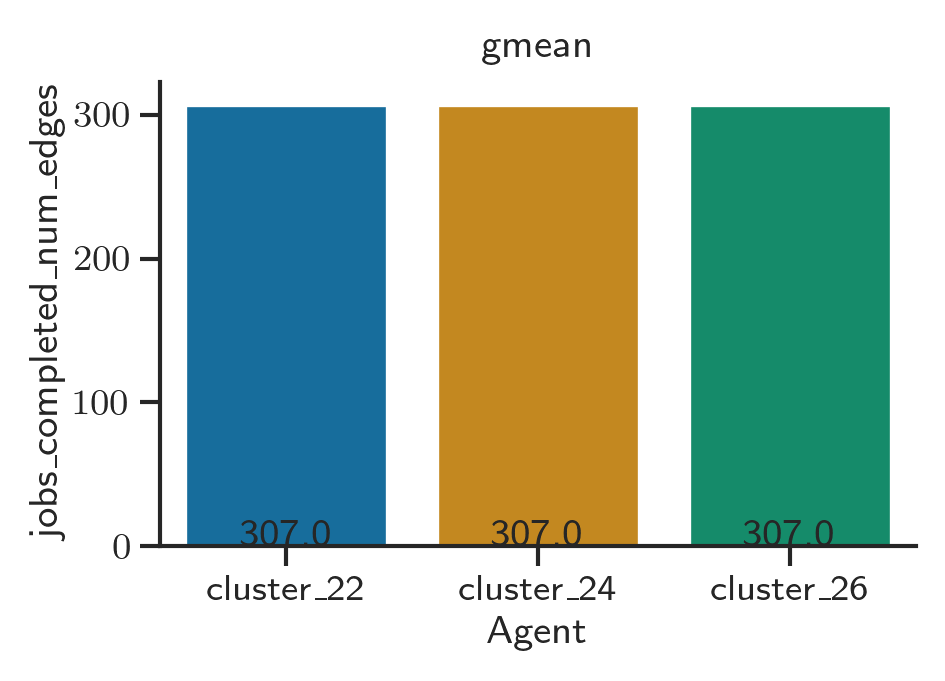

Plotting metric jobs_completed_num_nodes


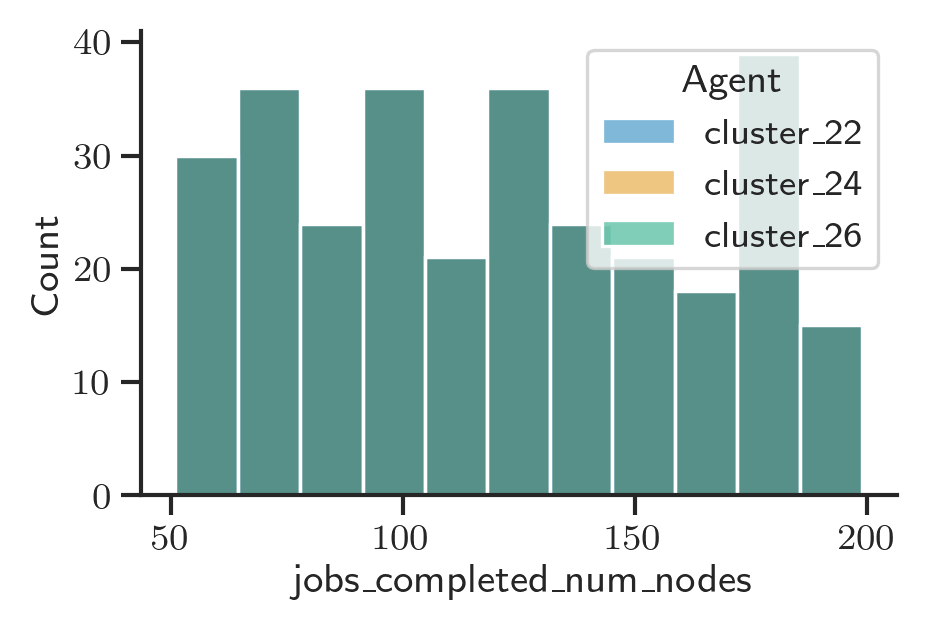

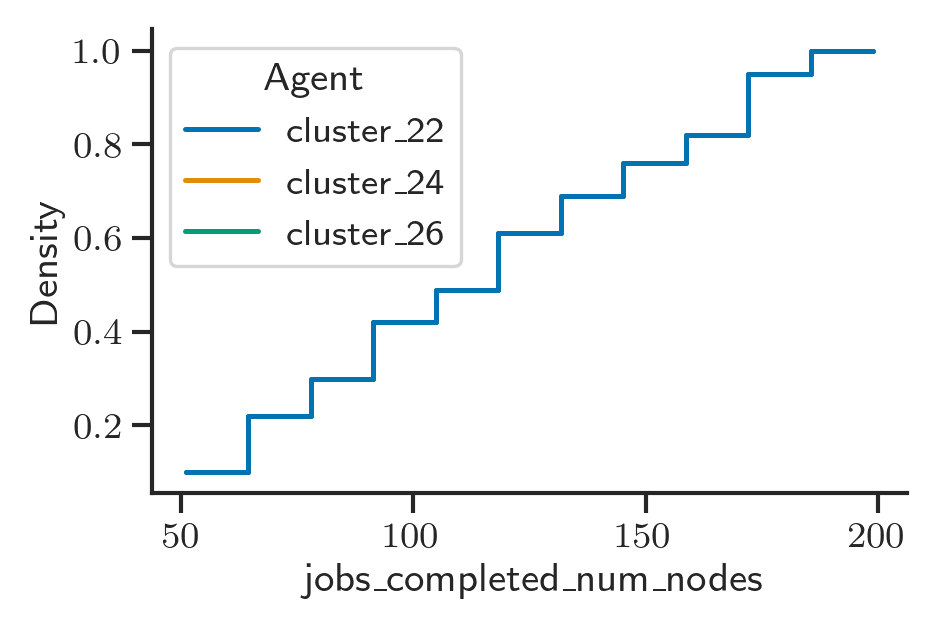

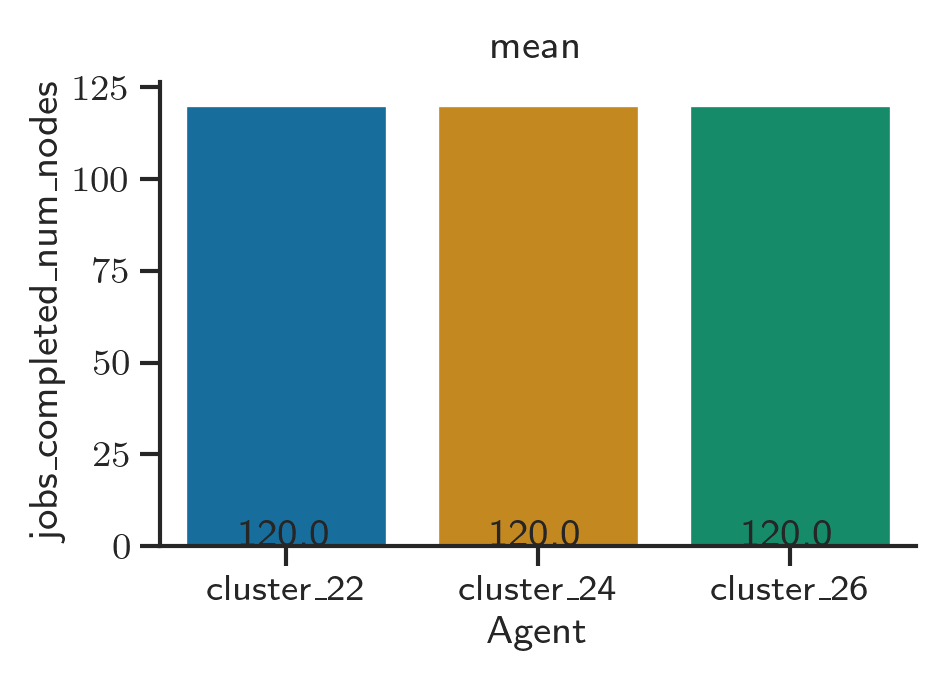

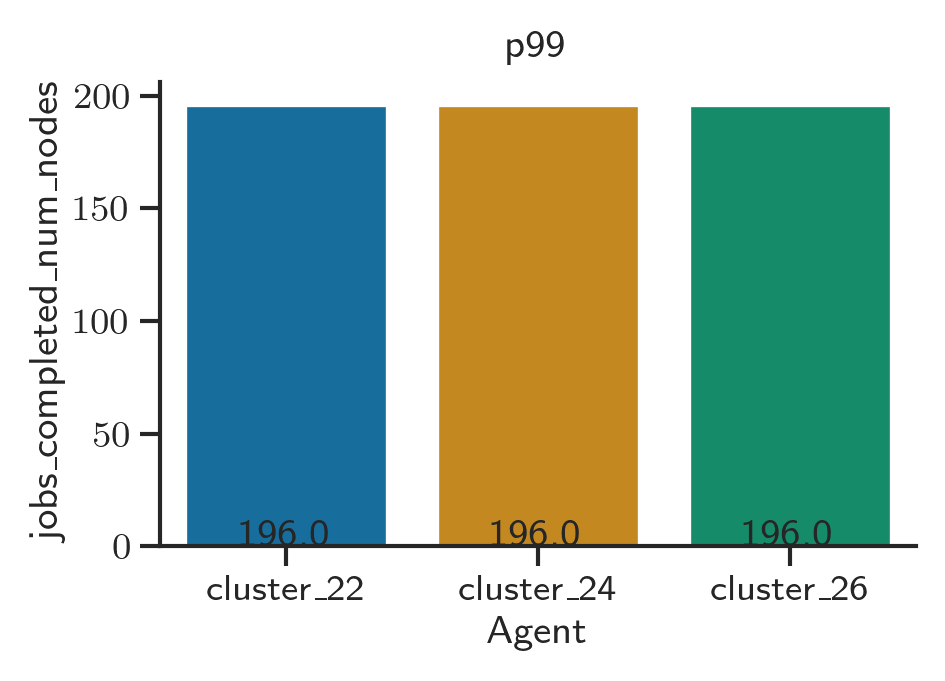

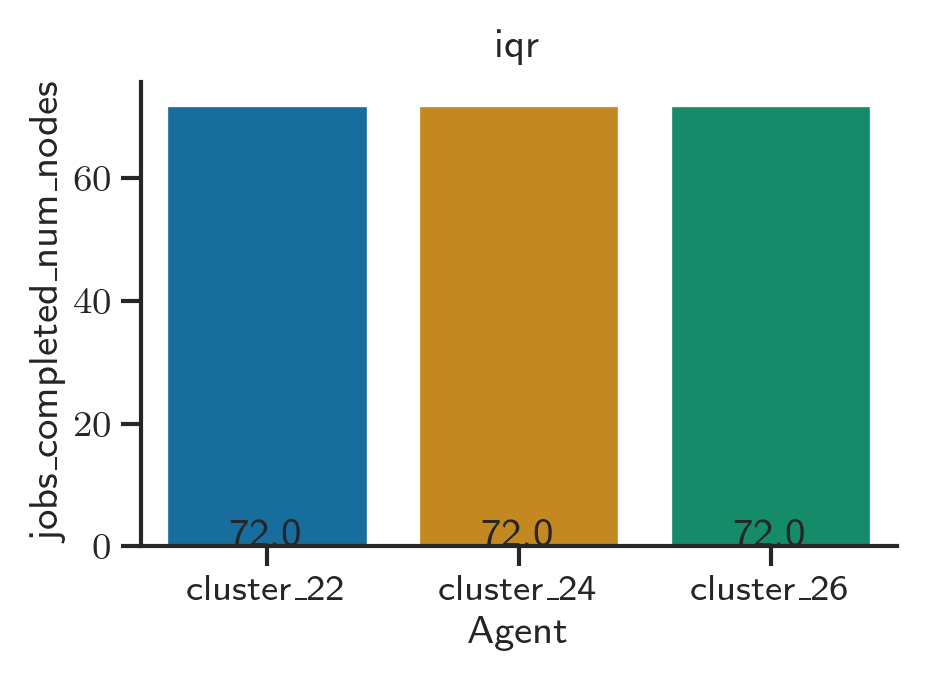

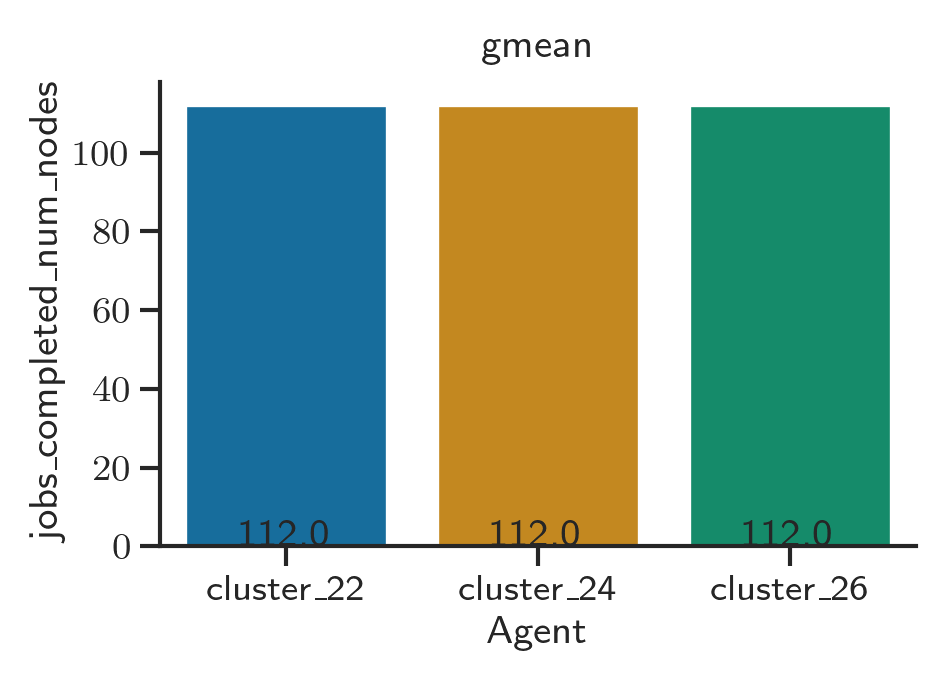

Plotting metric jobs_completed_total_dependency_size


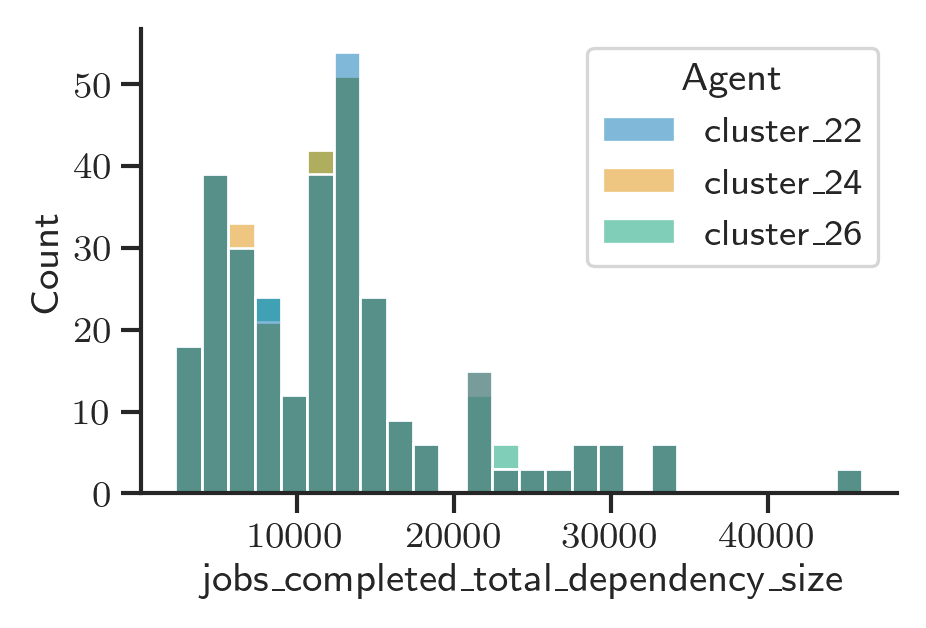

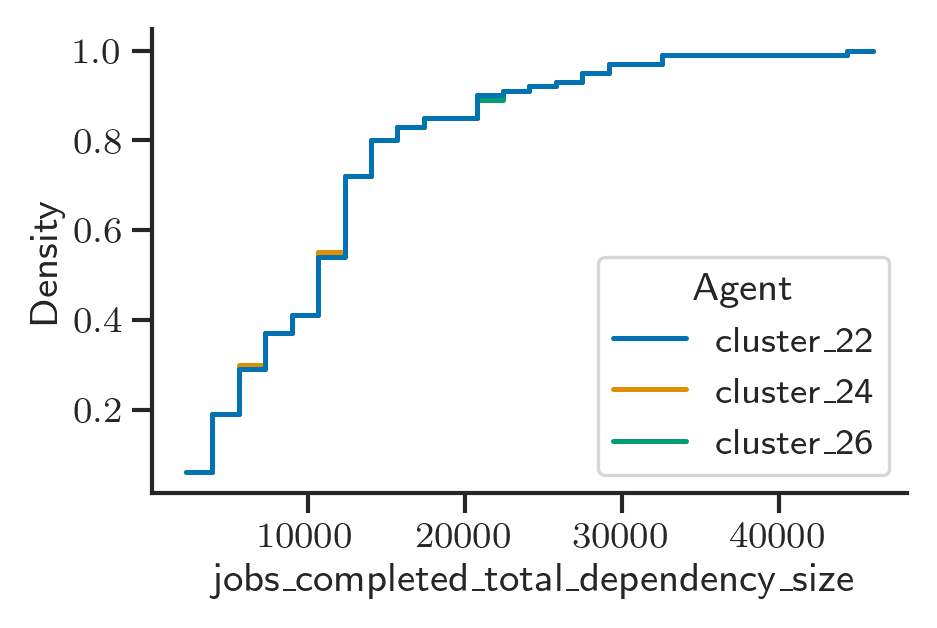

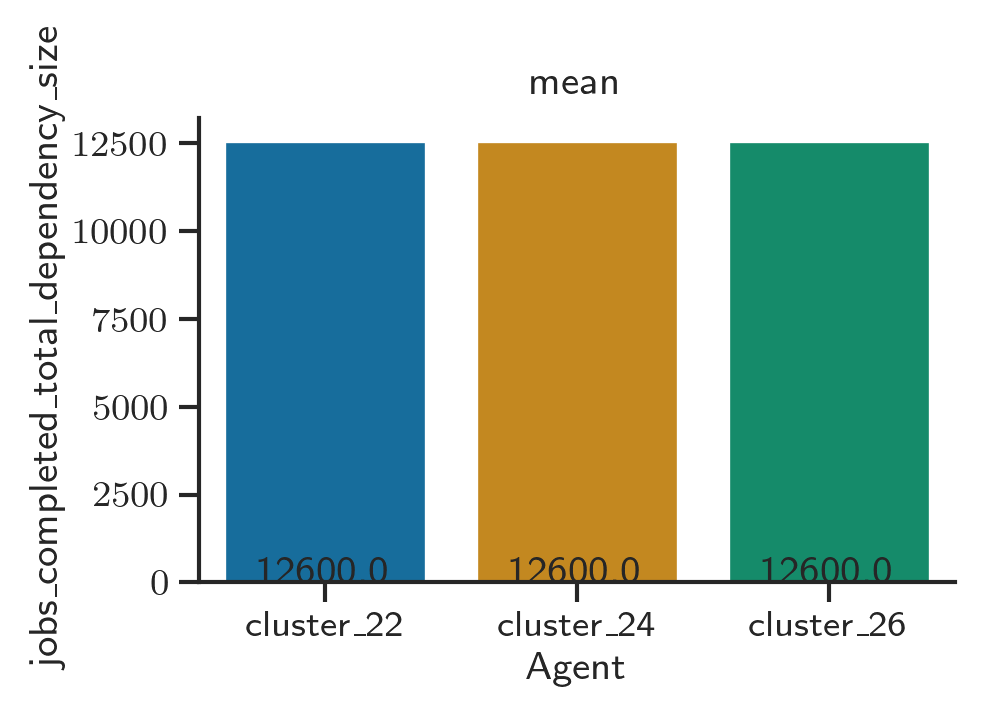

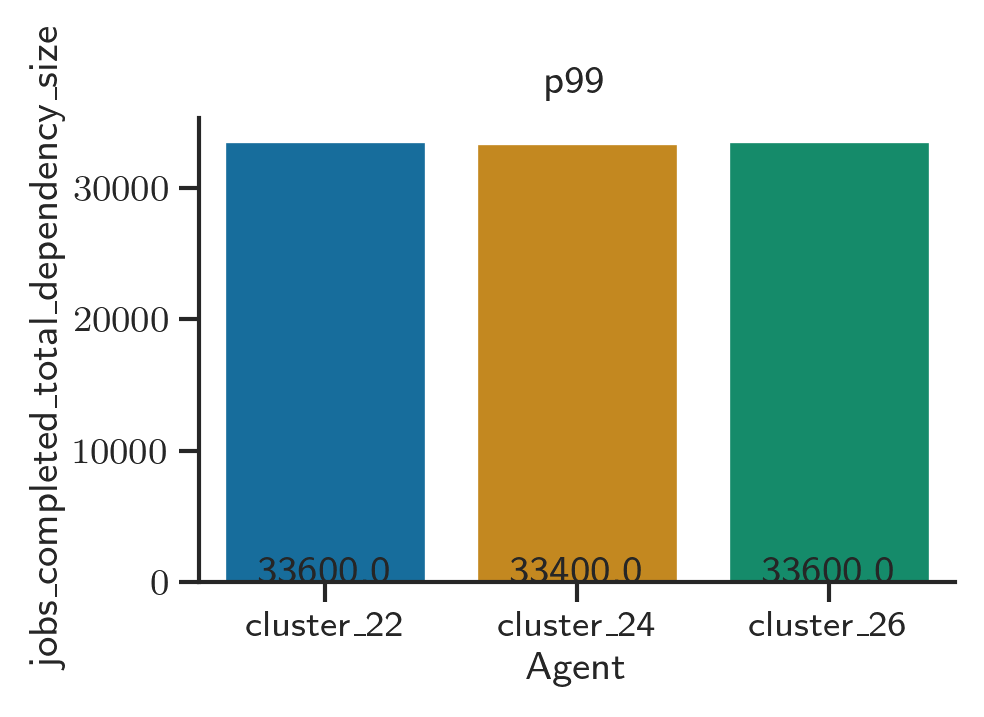

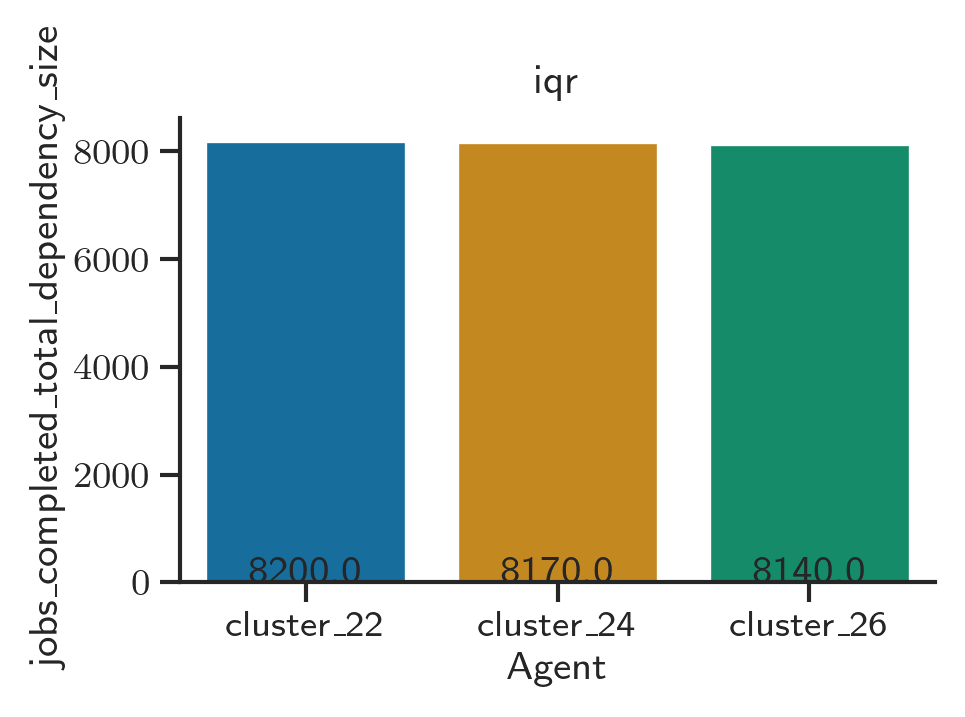

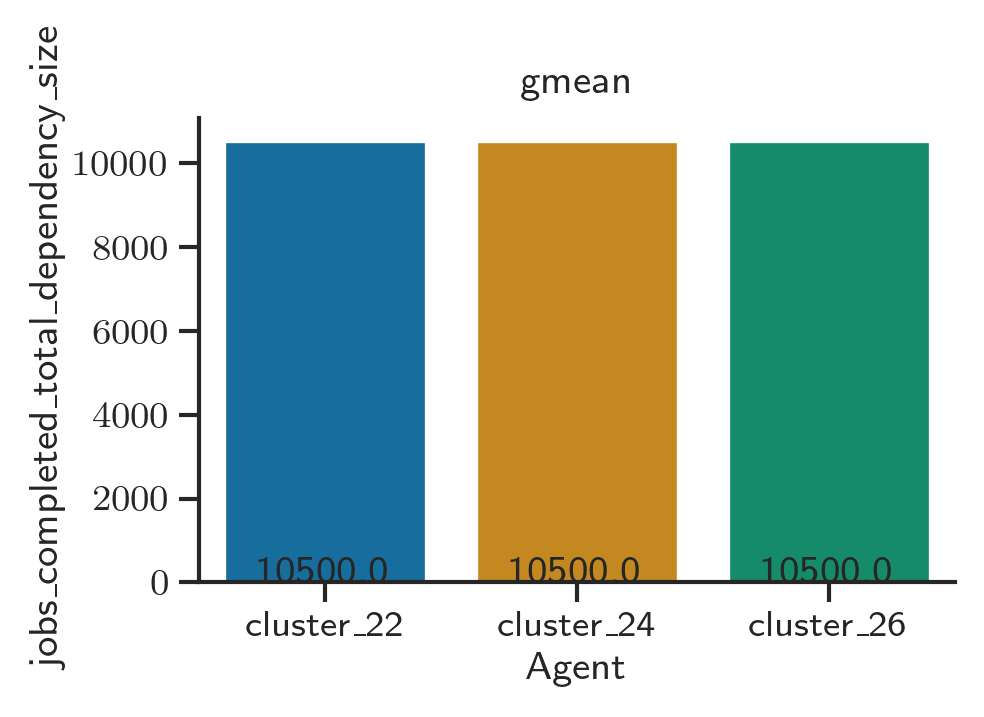

Plotting metric jobs_completed_total_operation_memory_cost


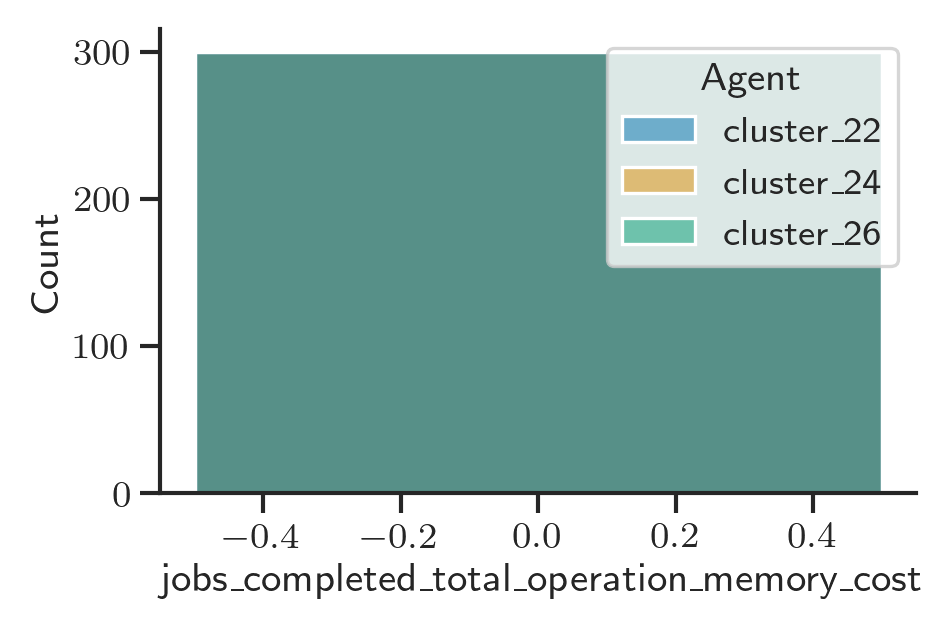

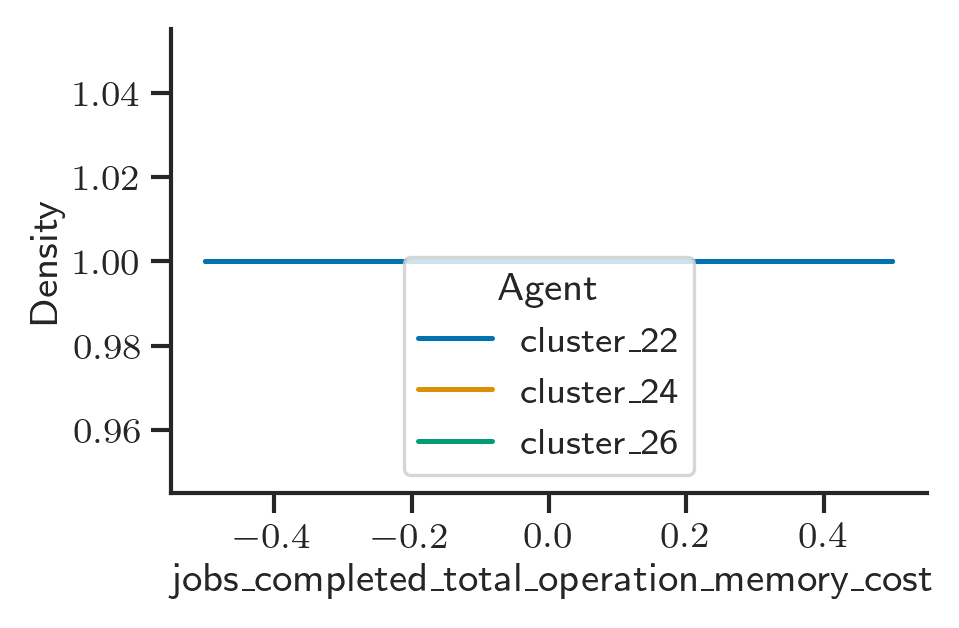

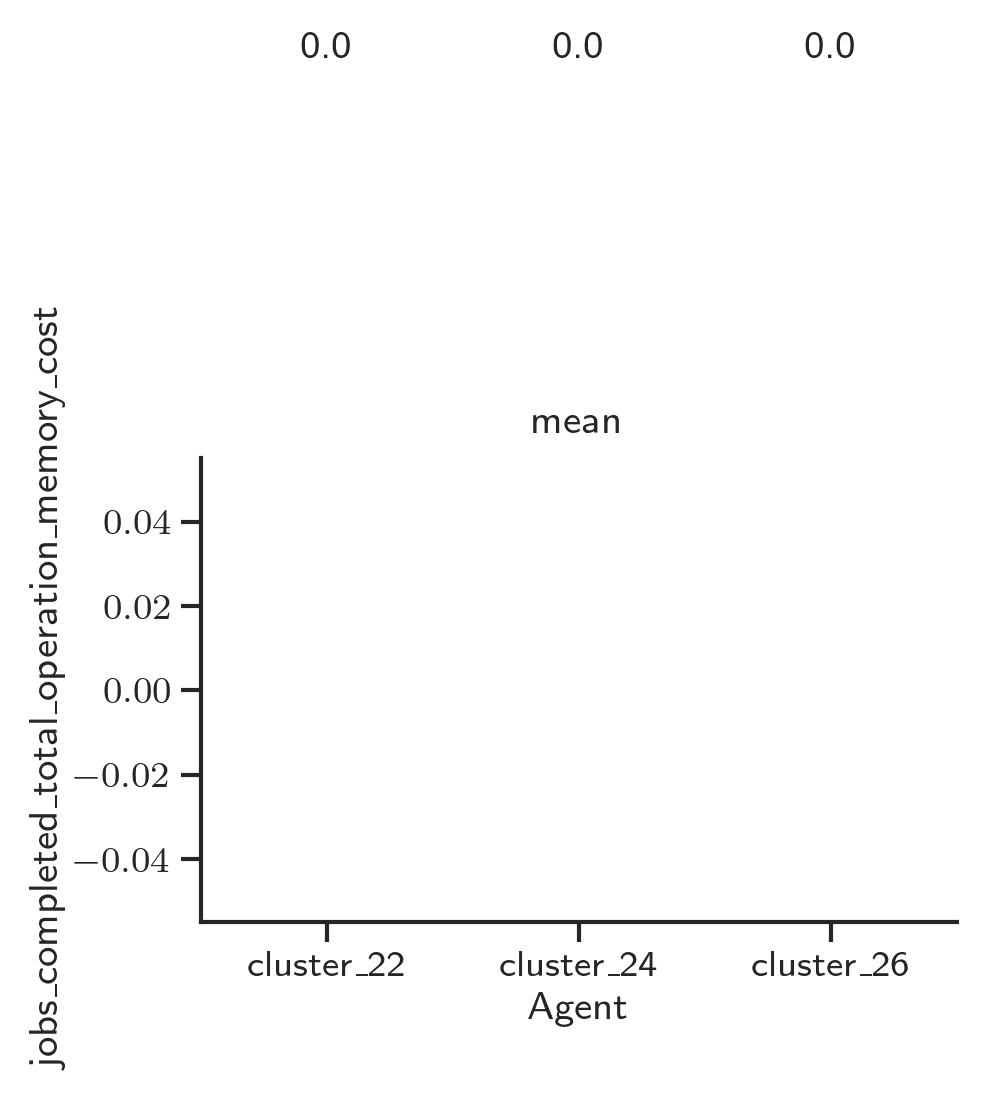

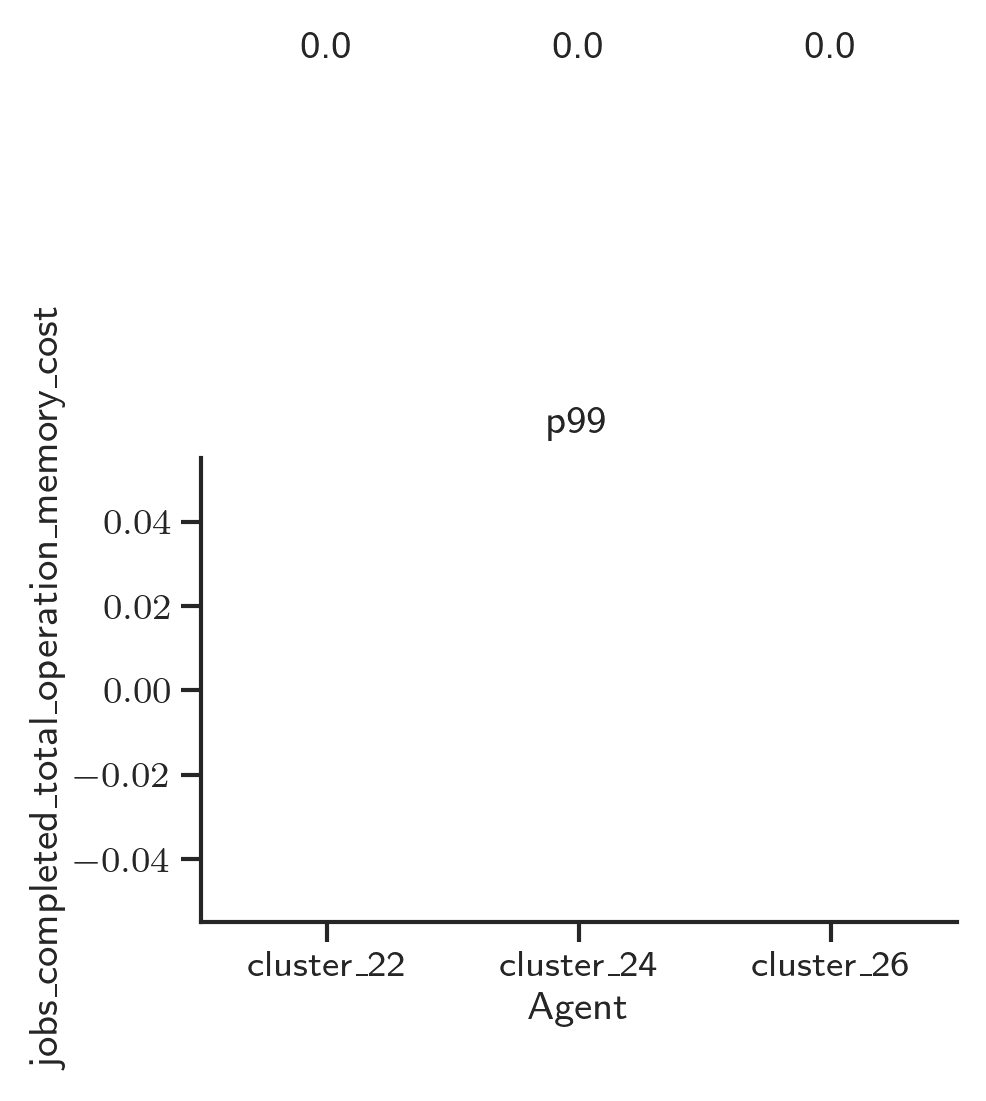

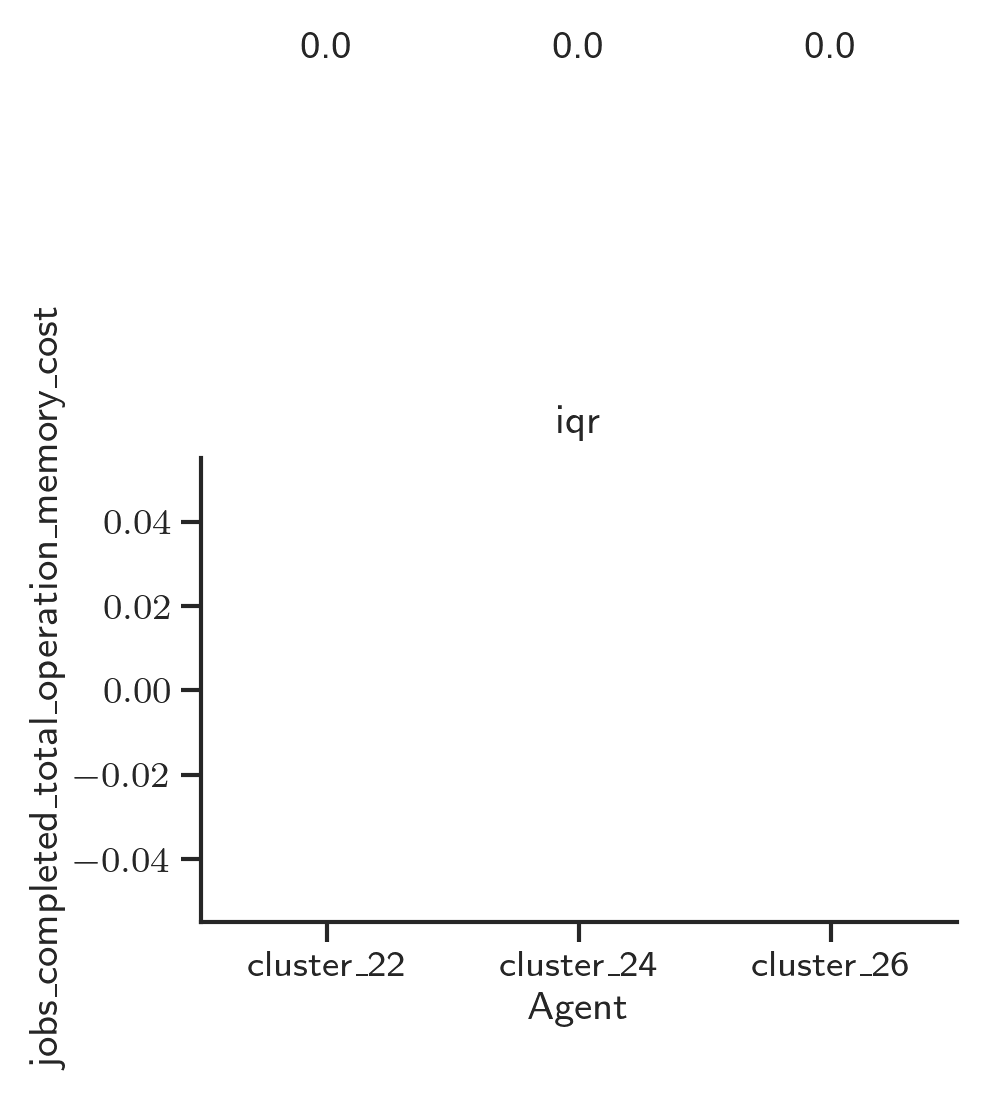

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/scipy/stats/stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


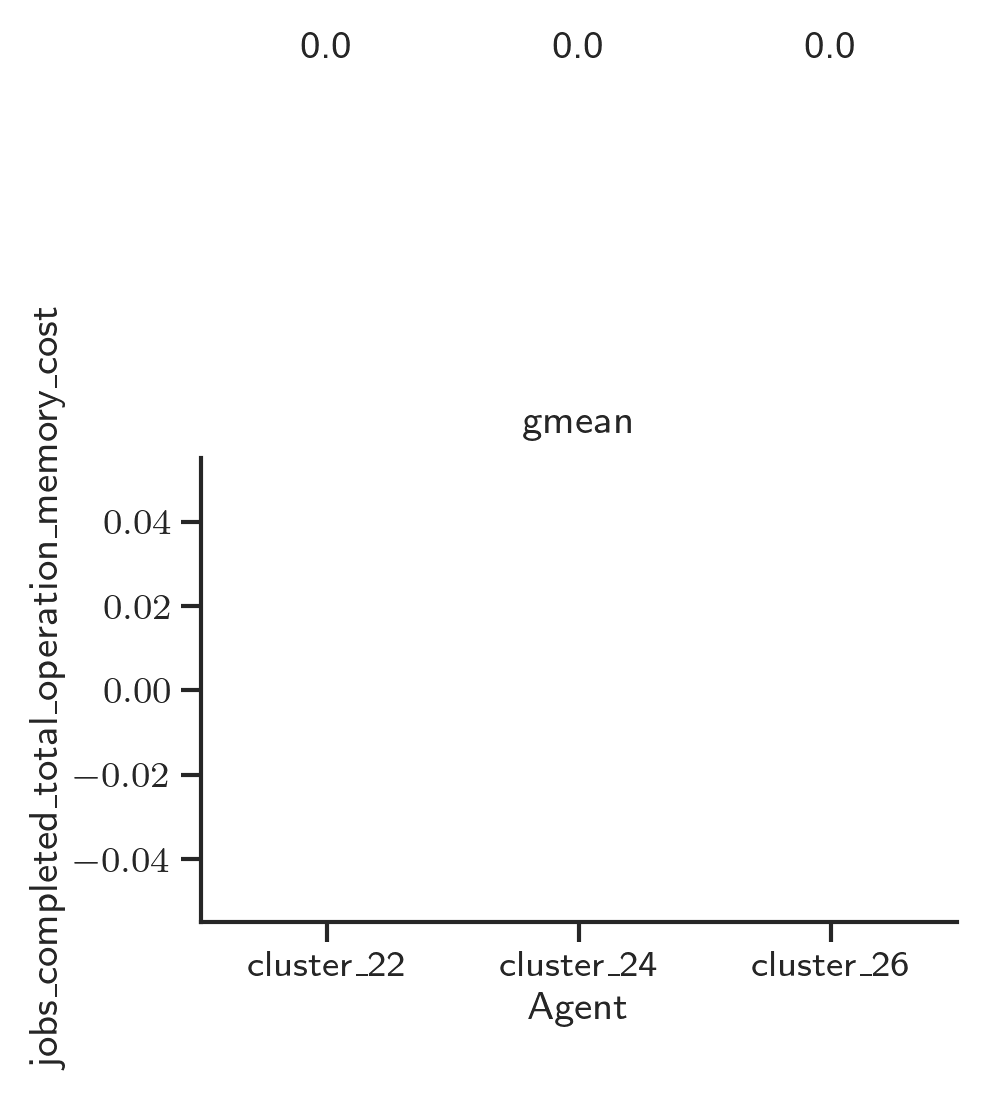

In [40]:
%autoreload

# plot config
scaling_factor = 1
metrics_to_skip = {}
def p99(a):
    return np.percentile(a, 99)
estimators = {'mean': np.mean,
              'p99': p99,
              'iqr': st.iqr,
              'gmean': st.gmean}


# make plots
metrics = sim_logs_dict[agent].keys()
metrics_to_plot = sorted([metric for metric in metrics if metric not in metrics_to_skip])
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = defaultdict(list)
    for _agent in sim_logs_dict.keys():
        plot_dict['Agent'].extend([_agent for _ in range(len(sim_logs_dict[_agent][metric]))])
        plot_dict[metric].extend(sim_logs_dict[_agent][metric])
        
    df = pd.DataFrame(plot_dict)
        
    # hist
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='bars',
                    fill=True,
                    cumulative=False,
                    stat='count',
                    multiple='layer',
                    scaling_factor=scaling_factor,
                    show_fig=True)
    
    # cdf
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='step',
                    fill=False,
                    cumulative=True,
                    stat='density',
                    common_norm=False,
                    scaling_factor=scaling_factor,
                    show_fig=True)
        
    # bar chart
    for estimator_name, estimator in estimators.items():
        fig = plot_bar(df, 
                        x='Agent', 
                        y=metric, 
                        xlabel='Agent', 
                        ylabel=metric, 
                        estimator=estimator,
                        title=estimator_name,
                        scaling_factor=scaling_factor,
                        show_fig=True)